In [1]:
from data_provider.data_loader import sequence_data_loader
import sys
sys.path.append("...")
from models.Autoencoder import AE
from models.Transformer import Transforemer_Encoder
import numpy as np
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt
from torch import nn
plt.rcParams['font.sans-serif'] = 'Simsun'
plt.rcParams.update({'font.size': 12}) # 改变所有字体大小，改变其他性质类似

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

C:\Users\dell\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [3]:
feature_size=27
data_path="PHM2012/时域频域特征提取/退化比例0.5/"
header=None
output_feature_size=27
sequence_length=64

data_train_loader,data_val_loader,data_test_loader=sequence_data_loader(feature_size,data_path,header,output_feature_size,sequence_length,degradation_ratio=0.8)


x_train shape: (6049, 64, 27)
x_test shape: (2463, 64, 27)
(4707, 64, 27)
训练集的特征形状, x_train ： torch.Size([6049, 64, 27])
训练集的标签形状, y_train ： torch.Size([6049])
验证集的特征性状，x_val ： torch.Size([2463, 64, 27])
验证集的标签形状，y_val ： torch.Size([2463])
测试集的特征形状, x_test ： torch.Size([4707, 64, 27])
测试集的标签形状, y_test ： torch.Size([4707])


In [4]:
###设置transformer的基本参数

# define and load model
model = Transforemer_Encoder(embedding_encoder=None,embedding_size=27,feature_size=256,
                             nhead=2, num_layers=2, dropout=0.25).to(device)


In [12]:

##output.detach().cpu().numpy())#能缩短计算时间
def Epoch_evaluate(net, loader):
    net.eval()
    min_val_loss = 0.0
    val_rmse = 0.0
    val_score = 0.0
    i = 0
    preds = []
    true = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            #             data = data.view(-1, input_channels, seq_length)#permute(0,2,1)#
            # 上述一步是Torch中卷积操作独有的，如果是LSTM，transformer可以注释掉这行代码

            output = net(data)
            output = output.squeeze(1)

            preds.append(output.detach().cpu().numpy())
            true.append(target.detach().cpu().numpy())

            min_val_loss += Losses(output, target).item()
            i += 1
        min_val_loss = min_val_loss / i
        val_rmse = np.sqrt(min_val_loss)
        preds = np.concatenate(preds)
        true = np.concatenate(true)
        #         val_score =np.float(Scoring_2008(true,preds))
        return round(min_val_loss, 5), np.round(val_rmse, 5)

# 现在都是对的了
def Last_evaluate2(net, loader):
    net.eval()
    min_val_loss = 0.0
    np_mse = 0.0
    preds = []
    true = []
    i = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            #             data = data.view(-1, input_channels, seq_length)#permute(0,2,1)
            # 上述一步是Torch中卷积操作独有的，如果是LSTM，transformer可以注释掉这行代码
            output = net(data)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(target.detach().cpu().numpy())
            min_val_loss += Losses(output, target).item()
            i += 1
        min_val_loss = min_val_loss / i
        preds = np.concatenate(preds)
        true = np.concatenate(true)
        return np.round(preds, 4), np.round(true, 5)



In [13]:
epochs = 300
steps = 0

# initialize Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epoch_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=0.5,patience=50,min_lr=0.001)###设置学习率下降策略，连续50次loss没有下降，学习率为原来的0.1倍，最小值为0.0001
Losses = nn.MSELoss()


###这个patience是连续150次，loss还是没有下降就停止运行
patience = 100
###这个是用于更新初始的val_loss的阈值
T_val_loss = 9999
counter = 0
train_loss = []
train_flood = []
val_loss = []
all_epochs = []
lr_step = []
###这个是模型权重的保存
save_dir = "model/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for epoch in range(1, epochs + 1):
    epoch_loss = 0
    flood_loss = 0
    model.train()
    for batch_idx, (data, target) in enumerate(data_train_loader):
        total = 0
        data, target = data.to(device), target.to(device)
        # data = data.view(-1, input_channels, seq_length)#permute(0,2,1)
        # 上述一步是Torch中卷积操作独有的，如果是LSTM，transformer可以注释掉这行代码

        optimizer.zero_grad()
        output = model(data)
        output = output.squeeze(1)
        loss = Losses(output, target)
        loss.backward()
        #         #这里添加梯度回退技巧，有一篇论文用到，你们可以试试
        #         b = torch.Tensor([145]).to(device)
        #         flood = (loss-b).abs()+b
        #         flood.backward()
        optimizer.step()

        epoch_loss += loss.item()
        #         flood_loss +=loss.item()
        total = batch_idx + 1
    epoch_loss = epoch_loss / total
    #     flood_loss = flood_loss/total
    ##############################还是要注意，不能把你要测试的数据放在这里进行验证####################################
    """不能使用是data_test_loader的数据作为  验证集，否则是算作弊
         需要做的办法：从训练集中随机，打乱抽取0.1-0.3的样本作为验证集 data_val_loader
         这个在TensorFlow中始很容易实现，但是Torch中我这一块没有研究，我自己代码是以TF2.X框架为主
         这个你们需要自己去查查，怎么制作新的validdata
    """
    min_val_loss, val_rmse = Epoch_evaluate(model, data_val_loader)  ###

    # 学习率衰减策略
    epoch_scheduler.step(min_val_loss)
    lr_current = optimizer.param_groups[0]['lr']
    lr_step.append(lr_current)

    print('epoch [{}/{}], loss:{:.4f}, val_loss:{}, val_RMSE:{}, lr:{}'.format(epoch, epochs,
                                                                               epoch_loss, min_val_loss, val_rmse,
                                                                               lr_current))  # {:.4f}
    ##这里是保存最后一个epoch的权重
    torch.save(model.state_dict(), os.path.join(save_dir, "model_on_last_epoch.pth"))

    if epoch % 1 == 0:
        train_loss.append(epoch_loss)
        val_loss.append(min_val_loss)
        all_epochs.append(epoch)
    """这里是设置训练的early stop patience """
    # 对测试集上的test_loss进行监视，并设置patience，保存在测试集上表现最好的model
    if T_val_loss >= min_val_loss:
        T_val_loss = min_val_loss
        # print("Saving...")
        best_epoch = epoch  # 找到最佳的epoch编号
        torch.save(model.state_dict(), os.path.join(save_dir, "model_onTestBest.pth"))
        counter = 0
    else:
        counter += 1
    if counter == patience:
        break


epoch [1/300], loss:0.1906, val_loss:0.19745, val_RMSE:0.44436, lr:0.001
epoch [2/300], loss:0.1681, val_loss:0.49527, val_RMSE:0.70376, lr:0.001
epoch [3/300], loss:0.2199, val_loss:0.19745, val_RMSE:0.44435, lr:0.001
epoch [4/300], loss:0.1792, val_loss:0.19744, val_RMSE:0.44435, lr:0.001
epoch [5/300], loss:0.1792, val_loss:0.19744, val_RMSE:0.44434, lr:0.001
epoch [6/300], loss:0.1792, val_loss:0.19739, val_RMSE:0.44428, lr:0.001
epoch [7/300], loss:0.1285, val_loss:0.62408, val_RMSE:0.78999, lr:0.001
epoch [8/300], loss:0.2619, val_loss:0.1927, val_RMSE:0.43897, lr:0.001
epoch [9/300], loss:0.1594, val_loss:0.19129, val_RMSE:0.43737, lr:0.001
epoch [10/300], loss:0.1520, val_loss:0.15901, val_RMSE:0.39876, lr:0.001
epoch [11/300], loss:0.1411, val_loss:0.14758, val_RMSE:0.38417, lr:0.001
epoch [12/300], loss:0.1308, val_loss:0.13359, val_RMSE:0.3655, lr:0.001
epoch [13/300], loss:0.1302, val_loss:0.1302, val_RMSE:0.36084, lr:0.001
epoch [14/300], loss:0.1278, val_loss:0.12887, val

epoch [112/300], loss:0.1158, val_loss:0.12539, val_RMSE:0.35411, lr:0.001
epoch [113/300], loss:0.1153, val_loss:0.12528, val_RMSE:0.35395, lr:0.001
epoch [114/300], loss:0.1159, val_loss:0.12529, val_RMSE:0.35396, lr:0.001
epoch [115/300], loss:0.1157, val_loss:0.12523, val_RMSE:0.35387, lr:0.001
epoch [116/300], loss:0.1160, val_loss:0.12524, val_RMSE:0.35389, lr:0.001
epoch [117/300], loss:0.1159, val_loss:0.12521, val_RMSE:0.35385, lr:0.001
epoch [118/300], loss:0.1157, val_loss:0.12524, val_RMSE:0.35389, lr:0.001
epoch [119/300], loss:0.1157, val_loss:0.1253, val_RMSE:0.35398, lr:0.001
epoch [120/300], loss:0.1152, val_loss:0.1253, val_RMSE:0.35398, lr:0.001
epoch [121/300], loss:0.1160, val_loss:0.12524, val_RMSE:0.3539, lr:0.001
epoch [122/300], loss:0.1152, val_loss:0.12531, val_RMSE:0.354, lr:0.001
epoch [123/300], loss:0.1155, val_loss:0.12536, val_RMSE:0.35406, lr:0.001
epoch [124/300], loss:0.1156, val_loss:0.12533, val_RMSE:0.35402, lr:0.001
epoch [125/300], loss:0.1158, 

epoch [222/300], loss:0.1149, val_loss:0.12486, val_RMSE:0.35335, lr:0.001
epoch [223/300], loss:0.1146, val_loss:0.12488, val_RMSE:0.35338, lr:0.001
epoch [224/300], loss:0.1151, val_loss:0.12486, val_RMSE:0.35336, lr:0.001
epoch [225/300], loss:0.1148, val_loss:0.1248, val_RMSE:0.35327, lr:0.001
epoch [226/300], loss:0.1149, val_loss:0.12483, val_RMSE:0.35332, lr:0.001
epoch [227/300], loss:0.1149, val_loss:0.12487, val_RMSE:0.35336, lr:0.001
epoch [228/300], loss:0.1150, val_loss:0.12488, val_RMSE:0.35338, lr:0.001
epoch [229/300], loss:0.1149, val_loss:0.1249, val_RMSE:0.35341, lr:0.001
epoch [230/300], loss:0.1153, val_loss:0.12489, val_RMSE:0.3534, lr:0.001
epoch [231/300], loss:0.1150, val_loss:0.12488, val_RMSE:0.35338, lr:0.001
epoch [232/300], loss:0.1147, val_loss:0.12489, val_RMSE:0.35339, lr:0.001
epoch [233/300], loss:0.1145, val_loss:0.12486, val_RMSE:0.35335, lr:0.001
epoch [234/300], loss:0.1149, val_loss:0.12487, val_RMSE:0.35337, lr:0.001
epoch [235/300], loss:0.1152

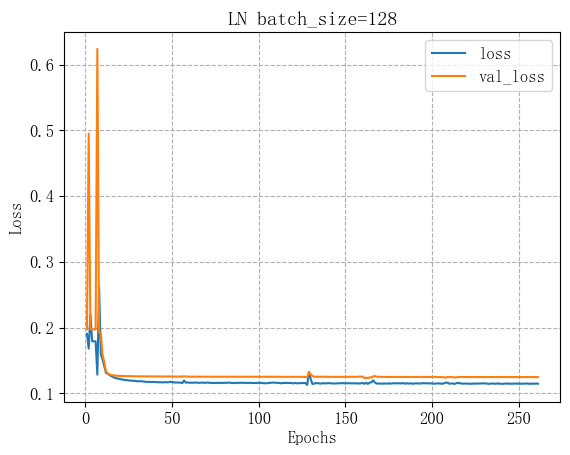

In [14]:
"""训练loss查看"""
#没有划分验证集，所以这个是测试集数据
plt.grid(linestyle="--")
plt.plot(all_epochs,train_loss)
plt.plot(all_epochs,val_loss)
plt.title('LN batch_size=128')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.savefig('model/loss.png' ,bbox_inches='tight', dpi=300)  # 600
plt.show()

In [15]:
"""评估"""
model.load_state_dict(torch.load(os.path.join(save_dir, "model_onTestBest.pth")))
train_metrics=[]
test_metrics =[]
train_metrics = Epoch_evaluate(model,data_train_loader)
test_metrics = Epoch_evaluate(model,data_test_loader) 
print('epoch [{}/{}], loss:{:.4f},     RMSE:{},'.format(best_epoch,epochs,train_metrics[0],train_metrics[1]))
print('epoch [{}/{}], val_loss:{:.4f}, val_RMSE:{}'.format(best_epoch,epochs,test_metrics[0],test_metrics[1]))

epoch [161/300], loss:0.1130,     RMSE:0.33611,
epoch [161/300], val_loss:0.1076, val_RMSE:0.32799


In [18]:
##保存评价指标：对于轴承
df = pd.DataFrame({'MSE':[train_metrics[0]] ,
                   'RMSE': [train_metrics[1]],})

df.transpose().to_csv("model/评估得分.txt",
                      mode='w',header=['train'],sep=' ',index=["MSE","RMSE"])
df = pd.DataFrame({'MSE':[test_metrics[0]] ,
                   'RMSE': [test_metrics[1]],})

df.transpose().to_csv("model/评估得分.txt",
                      mode='a',header=['test'],sep=' ',index=["MSE","RMSE"])

# 四.轴承RUL预测与可视化

## 训练集的预测

In [19]:
##训练集的预测
y_train_preds,y_train_true = Last_evaluate2(model,data_train_loader)

In [20]:
y_train_true.shape

(6049,)

In [21]:
"""保存预测的RUL值与实际的RUL值"""

y_train_All=pd.DataFrame({'Pre':y_train_preds,
                   'Actual':y_train_true})
y_train_All.to_csv("model/y_train_Pre.csv",
                      mode='w',header=["Pre","Actual"],sep=',',index=0)

## 测试集的预测

In [22]:
##测试集的预测
y_test_preds,y_test_true = Last_evaluate2(model,data_test_loader)

In [23]:
"""保存预测的RUL值与实际的RUL值"""

y_All=pd.DataFrame({'Pre':y_test_preds,
                   'Actual':y_test_true})
y_All.to_csv("model/y_test_Pre.csv",
                      mode='w',header=["Pre","Actual"],sep=',',index=0)

## 轴承的可视化以及RUL预测数据的保存

In [24]:
# 可视化
"""这里轴承的可视化，不包括ma、eam、SG滤波三种平滑方法，有兴趣自己添加或者再找我"""
"""这里以XJTU-SY_Bearing_Datasets\37.5Hz11kN的数据集为例
训练集:   Bearing2-1：长度491
              Bearing2-2：长度161
              Bearing2-3：长度533
测试集:   Bearing2-4：长度42
              Bearing2-5：长度339
"""
from sklearn.metrics import mean_squared_error

def calculateScore(y_pred, y_test):
    y_pred = list(map(lambda x: x[0], y_pred))
    return mean_squared_error(y_pred, y_test)

def plotUnitLines_y_test(y_test, y_pred, unit, Bpath='', figsize=[8, 6], plotname='', dirs=None):

    mse = mean_squared_error(y_test, y_pred)

    x = range(len(y_pred))

    data_list = []
   

    fig = plt.figure(figsize=figsize)
   
    plt.plot(x, y_pred, color="red", label='原始预测', linewidth=1)
    plt.plot(x, y_test, color='blue', label='实际值', linewidth=1)
    plt.xlim(0, max(x))
    plt.ylim(0, )
    plt.grid(linestyle="--")
    plt.title('Bearing1_' + str(unit) + ', MSE: ' + str('%.5f' % mse) ,
              fontsize=12)
    plt.ylabel('RUL(%)', fontsize=12)
    plt.xlabel('Running Time (*10s)', fontsize=12)
    plt.legend(fontsize=12)
    fig.tight_layout()

    if len(plotname) > 0:
        save_dir = dirs + Bpath
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.savefig(save_dir + plotname + ".png", bbox_inches='tight', dpi=300, format='png')  # 600
        np.savetxt(save_dir + plotname + "RULPre.csv", y_pred)
        np.savetxt(save_dir + plotname + "Act_RUL.csv", y_test)
        np.savetxt(save_dir + plotname + "x_axis.csv", x)
    plt.show()

## 注意用y_test_true和y_train_true绘图会出现锯齿

In [25]:
###训练集可视化
plotUnitLines_y_test(y_train_preds[:2803], y_train[:2803], unit=1, 
                     Bpath="best_epoch_result/B1_1/", figsize=[8, 6], plotname='B1_1_', dirs=save_dir)
plotUnitLines_y_test(y_train_preds[2803:2803+871], y_train[2803:2803+871], unit=2,
                     Bpath="best_epoch_result/B1_2/", figsize=[8, 6], plotname='B1_2_', dirs=save_dir)
# plotUnitLines_y_test(y_train_preds[491+161: 491+161+533], y_train[491+161: 491+161+533 ], unit=3,
#                      Bpath="best_epoch_result/B1_3/", figsize=[8, 6], plotname='B1_3_', dirs=save_dir)

NameError: name 'y_train' is not defined

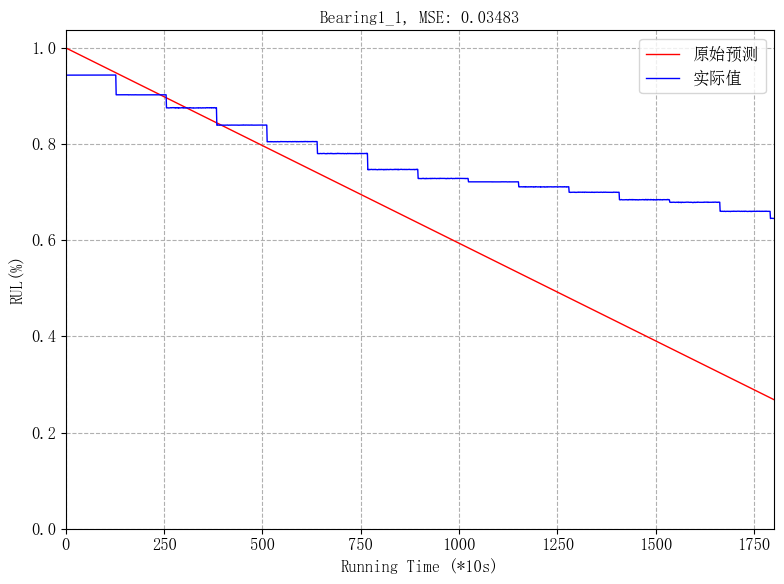

In [130]:
###测试集可视化
plotUnitLines_y_test(y_test_preds[:1802], y_test[:1802], unit=1, 
                     Bpath="best_epoch_result/B1_3/", figsize=[8, 6], plotname='B1_4_', dirs=save_dir)
# plotUnitLines_y_test(y_test_preds[42:42+339], y_test[42:42+339], unit=2,
#                      Bpath="best_epoch_result/B1_5/", figsize=[8, 6], plotname='B1_5_', dirs=save_dir)

### 上述图不是FFT和原始信号特征，效果果然不好，，，还是要在特征层面下足功夫